# TensorFlow 2 Image Classifier REST API 
By Hamed ZITOUN (https://www.linkedin.com/in/hamed-zitoun/) 

This code for the Medium story "🚀Create & Serve a TensorFlow 2.2 Deep Learning Classifier as a REST API (with GPU support), Part I"

👉 https://medium.com/@hzitoun/create-serve-a-tensorflow-2-2-deep-learning-classifier-as-a-rest-api-with-gpu-support-part-i-4767a8a22608 

## 1- Import tf2 & check GPU support

In [1]:
import tensorflow as tf
from tensorflow.python.client import device_lib

print("- TensorFlow version:", tf.__version__) #check version 2.2

print("- GPUs detected", tf.config.list_physical_devices('GPU'))

print("- Is TensorFlow built with CUDA? ", tf.test.is_built_with_cuda())

print("- GPU description")
[x for x in device_lib.list_local_devices() if x.device_type == 'GPU'] 

- TensorFlow version: 2.2.0
- GPUs detected [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
- Is TensorFlow built with CUDA?  True
- GPU description


[name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 1434376601
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 11886518309535854585
 physical_device_desc: "device: 0, name: GeForce GTX 960M, pci bus id: 0000:01:00.0, compute capability: 5.0"]

## 2- Import other required libs

In [37]:
import os
import datetime

import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()


from tqdm.notebook import tqdm


%matplotlib inline
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## 3- Load dataset

In [79]:
def read_image(image_path, image_size):
    """ read an image using opencv """
    
    image = cv2.imread(image_path) #BGR
    # convert to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # resize using cubic interpolation, a way to deal with missing data (upsize or downsize)
    image = cv2.resize(image, image_size, cv2.INTER_CUBIC) 
    
    return image

### Visualize some images

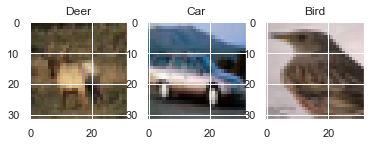

In [85]:
deer = read_image("../data/raw/train/3_deer.png", (32, 32))
car =  read_image("../data/raw/train/4_automobile.png", (32, 32)) 
bird =  read_image("../data/raw/train/18_bird.png", (32, 32)) 

plt.subplot(131)
plt.imshow(deer)
plt.title('Deer')
plt.subplot(132)
plt.imshow(car)
plt.title('Car')
plt.subplot(133)
plt.imshow(bird)
plt.title('Bird')

plt.show()

In [4]:
def load_dataset(lables_file_path, dataset_path, image_size):
    """ load data """
    
    with open(lables_file_path,  "r") as f:
        labels = f.read().splitlines() # ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
        
    images = []
    targets = []

    for image_file_name in tqdm(os.listdir(dataset_path), desc="loading images", unit="image loading"):
        
        try:
            image_path = os.path.join(dataset_path, image_file_name)
            images.append(read_image(image_path, image_size))
            
            for idx in range(len(labels)):
                if labels[idx] in image_file_name: #image file name contains its label
                    targets.append(idx)
        except Exception as e:
            pass
       
    return np.array(images), np.array(targets)

In [5]:
X_train, y_train= load_dataset("../data/raw/labels.txt", "../data/raw/train", (32, 32))
X_test, y_test= load_dataset("../data/raw/labels.txt", "../data/raw/test", (32, 32))

In [6]:
print("training data shapes")
print(X_train.shape) # 50000 images, 32x32 size with 3 channels 
print(y_train.shape) # 50000 class indexes
print("test data shapes")
print(X_test.shape) # 10000 images, 32x32 size with 3 channels 
print(y_test.shape) # 10000 class indexes

training data shapes
(50000, 32, 32, 3)
(50000,)
test data shapes
(10000, 32, 32, 3)
(10000,)


## 4- Create an Image Classification Deep Learning Model

![image.png](https://github.com/deep-diver/CIFAR10-img-classification-tensorflow/raw/master/conv_model.png) 

Image credit https://github.com/deep-diver/CIFAR10-img-classification-tensorflow/raw/master/conv_model.png 

### Define a Convolutional block

In [7]:
def conv_block(previous_layer_output, number_of_filters, kernel_size, 
               strides=(1, 1), padding="SAME", 
               activation = tf.keras.layers.Activation('relu'),
               layer_name="conv_layer"):
    '''  
    Defines convolutional layer with max pooling and batch noramlization
    '''

    layer = tf.keras.layers.Conv2D(filters=number_of_filters,
                                                   kernel_size=kernel_size,
                                                   strides=strides, 
                                                   padding=padding, # "VALID" = without padding, "SAME" = with zero padding
                                                   activation=activation, name=layer_name)(previous_layer_output)
    layer = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='SAME')(layer)
    layer = tf.keras.layers.BatchNormalization()(layer)
        
    return layer

### Define a Dense block

In [8]:
def dense_block(previous_layer_output,
                units, 
                activation = tf.keras.layers.Activation('relu'),
                drop_out_rate=0.3, layer_name="dense_layer"):
    """
    Defines dense block layer.
    """
    
    layer = dense_features = tf.keras.layers.Dense(units=units, activation=activation, name=layer_name)(previous_layer_output)
    layer = tf.keras.layers.Dropout(rate=drop_out_rate)(layer)
    layer = tf.keras.layers.BatchNormalization()(layer)
        
    return layer

### Method for creating our CNN classifier 

In [9]:
def create_model(image_size, drop_out_rate, number_of_classes):
    """ 
    Create a Keras model with 4 conv blocks, 1 flatten layer, 4 dense blocks and softmax ouput
    """
  
    inputs = tf.keras.Input(shape=(image_size[0], image_size[1], 3), dtype=tf.float32, name="inputs")
    normalized_images = tf.keras.layers.BatchNormalization()(inputs)
    
    # conv block 1
    conv_block_1 = conv_block(normalized_images, 
                                                   number_of_filters=64, 
                                                   kernel_size=(3, 3), 
                                                   strides=(1, 1), padding="SAME", 
                                                   activation = tf.keras.layers.Activation('relu'),
                                                   layer_name="conv_1_features")
    # conv block 2
    conv_block_2 = conv_block(conv_block_1, 
                                                   number_of_filters=128, 
                                                   kernel_size=(3, 3), 
                                                   strides=(1, 1), padding="SAME", 
                                                   activation = tf.keras.layers.Activation('relu'),
                                                   layer_name="conv_2_features")
    
    # conv block 3
    conv_block_3 = conv_block(conv_block_2, 
                                                   number_of_filters=256, 
                                                   kernel_size=(5, 5), 
                                                   strides=(1, 1), padding="SAME", 
                                                   activation = tf.keras.layers.Activation('relu'),
                                                   layer_name="conv_3_features")
    
    # conv block 4
    conv_block_4 = conv_block(conv_block_3, 
                                                   number_of_filters=512, 
                                                   kernel_size=(5, 5), 
                                                   strides=(1, 1), padding="SAME", 
                                                   activation = tf.keras.layers.Activation('relu'),
                                                   layer_name="conv_4_features")
    
    # flatten : reshape to on single vector (see model architecture above)
    flat_layer = tf.keras.layers.Flatten()(conv_block_4)
   
    
    # Dense block 1
    dense_block_1 = dense_block(flat_layer,
                                                        units=128,
                                                        activation= tf.keras.layers.Activation('relu'),
                                                        drop_out_rate=drop_out_rate,
                                                        layer_name="dense_1_features")
    
    # Dense block 2
    dense_block_2 = dense_block(dense_block_1,
                                                        units=256,
                                                        activation= tf.keras.layers.Activation('relu'),
                                                        drop_out_rate=drop_out_rate,
                                                        layer_name="dense_2_features")
    
    # Dense block 3
    dense_block_3 = dense_block(dense_block_2,
                                                        units=512,
                                                        activation= tf.keras.layers.Activation('relu'),
                                                        drop_out_rate=drop_out_rate,
                                                        layer_name="dense_3_features")
    
    # Dense block 4
    dense_block_4 = dense_block(dense_block_3,
                                                        units=1024,
                                                        activation= tf.keras.layers.Activation('relu'),
                                                        drop_out_rate=drop_out_rate,
                                                        layer_name="dense_4_features")
    # logits layer (the layer that feeds into softmax)
    logits = tf.keras.layers.Dense(units=number_of_classes, activation=None)(dense_block_4)
    
    predictions = tf.keras.layers.Softmax()(logits)
    
    # Instantiate a Keras model
    return tf.keras.Model(inputs=inputs, outputs=predictions, name="keras_image_classification_model")

### Define hyperameters

In [94]:
epochs = 50 # back to 5
learning_rate = 0.0001
decay=1e-6
batch_size = 512 # change it depending on your RAM
drop_out_rate = 0.6
image_size = (32, 32)

### Instantiate CNN classifier

In [11]:
model = create_model(image_size=image_size, drop_out_rate=drop_out_rate, number_of_classes=10)
model.summary()

Model: "keras_image_classification_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 32, 32, 3)]       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 3)         12        
_________________________________________________________________
conv_1_features (Conv2D)     (None, 32, 32, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
conv_2_features (Conv2D)     (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None

### Compile model

In [92]:
# learning_rate and decay is defined above in the hyperparameters definition section
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate, decay=decay), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])

### Training the model

In [95]:
from tqdm.keras import TqdmCallback
from tensorflow.keras.callbacks import ModelCheckpoint

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=5, 
                                                           restore_best_weights=True)

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

model.fit(x=X_train, y=y_train,
    batch_size=batch_size, # variable defined above
    epochs=epochs, # variable defined above
    verbose=0,
    shuffle=True,
    validation_data=(X_test, y_test),
    callbacks=[TqdmCallback(verbose=1, epochs=epochs, batch_size=batch_size), early_stopping_callback, tensorboard_callback])

In [89]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 13180), started 1:27:12 ago. (Use '!kill 13180' to kill it.)

### Evaluate the model

In [96]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)


target_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    airplane       0.84      0.86      0.85      1000
  automobile       0.92      0.92      0.92      1000
        bird       0.76      0.72      0.74      1000
         cat       0.63      0.67      0.65      1000
        deer       0.80      0.81      0.80      1000
         dog       0.74      0.72      0.73      1000
        frog       0.86      0.86      0.86      1000
       horse       0.87      0.86      0.86      1000
        ship       0.91      0.90      0.91      1000
       truck       0.88      0.89      0.88      1000

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000



### Make a test inference

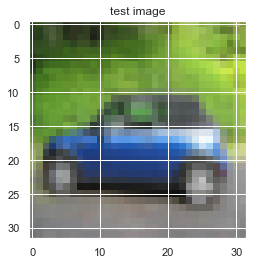

CNN sees automobile


In [107]:
test_image =  read_image("../data/raw/test/82_automobile.png", image_size) 
plt.imshow(test_image)
plt.title('test image')
plt.show()

pred_softmax = model.predict(test_image.reshape(1, image_size[0], image_size[1], 3))
pred_class_index = np.argmax(pred_softmax, axis=1)

target_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print("CNN sees", target_names[pred_class_index.item()])

## Export the model

In [110]:
model.save('../models/saved_image_classifier/')

INFO:tensorflow:Assets written to: ../models/saved_image_classifier/assets


### Check if it can be correctly loaded! 

In [114]:
loaded_model = tf.keras.models.load_model('../models/saved_image_classifier/')
loss, acc = loaded_model.evaluate(X_test,  y_test, verbose=0)
print('Accuracy: {:5.2f}%'.format(100*acc))

Accuracy: 82.02%
